In [1]:

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow / Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("saved_model/datasets/Language Detection.csv")
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [4]:
df.duplicated().sum()

np.int64(66)

In [5]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [6]:
df.Language.unique()

array(['English', 'Malayalam', 'Hindi', 'Tamil', 'Portugeese', 'French',
       'Dutch', 'Spanish', 'Greek', 'Russian', 'Danish', 'Italian',
       'Turkish', 'Sweedish', 'Arabic', 'German', 'Kannada'], dtype=object)

In [7]:
df.Language.value_counts() 

Language
English       1382
French        1007
Spanish        816
Portugeese     736
Italian        694
Russian        688
Sweedish       673
Malayalam      591
Dutch          542
Arabic         532
Turkish        471
German         465
Tamil          464
Danish         424
Kannada        366
Greek          358
Hindi           62
Name: count, dtype: int64

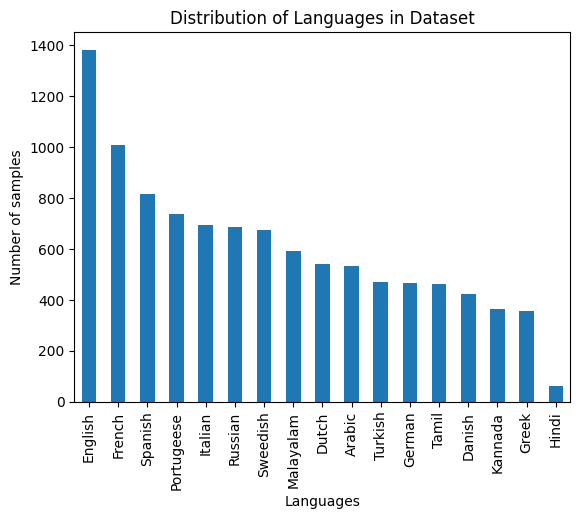

In [8]:
df.Language.value_counts().plot(kind='bar')
plt.xlabel('Languages')
plt.ylabel('Number of samples')
plt.title('Distribution of Languages in Dataset')
plt.show()

In [9]:
label_encoder = LabelEncoder()
df["Language_encoded"] = label_encoder.fit_transform(df["Language"])

In [10]:
print(df.Language.unique())
print(df.Language_encoded.unique())

['English' 'Malayalam' 'Hindi' 'Tamil' 'Portugeese' 'French' 'Dutch'
 'Spanish' 'Greek' 'Russian' 'Danish' 'Italian' 'Turkish' 'Sweedish'
 'Arabic' 'German' 'Kannada']
[ 3 10  7 15 11  4  2 13  6 12  1  8 16 14  0  5  9]


In [11]:
df.drop("Language_encoded", axis=1, inplace=True)
df["Language"] = label_encoder.fit_transform(df["Language"])

In [12]:
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Text"]) 

In [13]:
sequences = tokenizer.texts_to_sequences(df["Text"])
sequences[:3]

[[84, 8, 4, 11195, 4933, 22, 4, 702, 2714, 1386, 959, 115, 2715],
 [84, 152, 7998, 14, 4, 11196, 9, 4, 2714, 959, 11, 236, 14, 324, 8, 730],
 [4, 787, 9, 84, 22, 3, 1189, 255, 201, 4, 516, 468, 9, 602]]

In [14]:
X = pad_sequences(sequences, maxlen=60)
X

array([[   0,    0,    0, ...,  959,  115, 2715],
       [   0,    0,    0, ...,  324,    8,  730],
       [   0,    0,    0, ...,  468,    9,  602],
       ...,
       [   0,    0,    0, ...,    1,  650,    1],
       [   0,    0,    0, ...,  136, 8588,    1],
       [   0,    0,    0, ...,    1,  650,    1]],
      shape=(10271, 60), dtype=int32)

In [15]:
X.shape

(10271, 60)

In [16]:
y = df["Language"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

In [19]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(1.1758980964648633),
 1: np.float64(1.4256463647405866),
 2: np.float64(1.1135809162374628),
 3: np.float64(0.4425770308123249),
 4: np.float64(0.6063916156173887),
 5: np.float64(1.2751823684618966),
 6: np.float64(1.649467978317607),
 7: np.float64(8.949891067538127),
 8: np.float64(0.8569044639132248),
 9: np.float64(1.6327503974562798),
 10: np.float64(1.0304778627869058),
 11: np.float64(0.8095378855059612),
 12: np.float64(0.849374547710121),
 13: np.float64(0.736728837876614),
 14: np.float64(0.9240805308739174),
 15: np.float64(1.278555866791161),
 16: np.float64(1.3240934730056406)}

In [20]:
classes_ = label_encoder.classes_

In [21]:

model = Sequential([
    Embedding(input_dim=15000, output_dim=64, input_length=80),
    SimpleRNN(64),
    Dropout(0.3),
    Dense(len(classes_), activation="softmax")
])

c:\Users\shard\anaconda3\envs\venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [23]:

optimizer = Adam(learning_rate=0.0005)

In [24]:
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [25]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2001 - loss: 2.5517 - val_accuracy: 0.4608 - val_loss: 1.9533
Epoch 2/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6080 - loss: 1.4927 - val_accuracy: 0.7416 - val_loss: 1.1303
Epoch 3/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8137 - loss: 0.8920 - val_accuracy: 0.8779 - val_loss: 0.6472
Epoch 4/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9394 - loss: 0.4489 - val_accuracy: 0.9387 - val_loss: 0.3884
Epoch 5/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9632 - loss: 0.2661 - val_accuracy: 0.9440 - val_loss: 0.2924
Epoch 6/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9685 - loss: 0.1952 - val_accuracy: 0.9114 - val_loss: 0.3590
Epoch 7/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9727 - loss: 0.1645 - val_accuracy: 0.9518 - val_loss: 0.2026
Epoch 8/100
514/514 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9791 - loss: 0.1179 -

In [26]:

model.save("saved_model/simple_rnn_model.h5")

with open("saved_model/tokenizer.pkl", "wb") as f:
    pickle.dump((tokenizer, label_encoder), f)

print("Model training completed and saved.")

Model training completed and saved.


### **Model Loading**

In [27]:

model = load_model("saved_model/simple_rnn_model.h5")

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

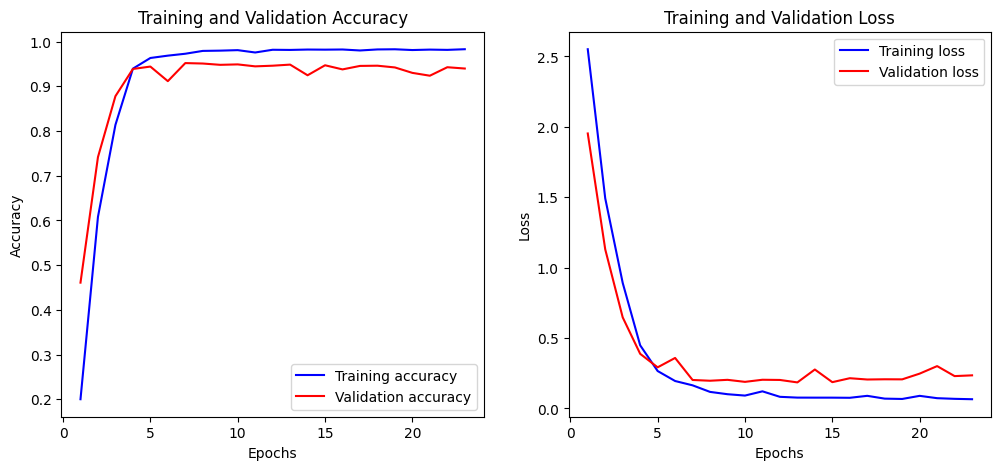

In [29]:
plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9484 - loss: 0.1853
Test Accuracy: 0.9484
Test Loss: 0.1853


In [31]:
# Predictions on Test Data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
# Finds the index of maximum probability

y_pred_classes[:10]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([16, 16,  4,  3, 11,  3,  0,  4,  6, 16])

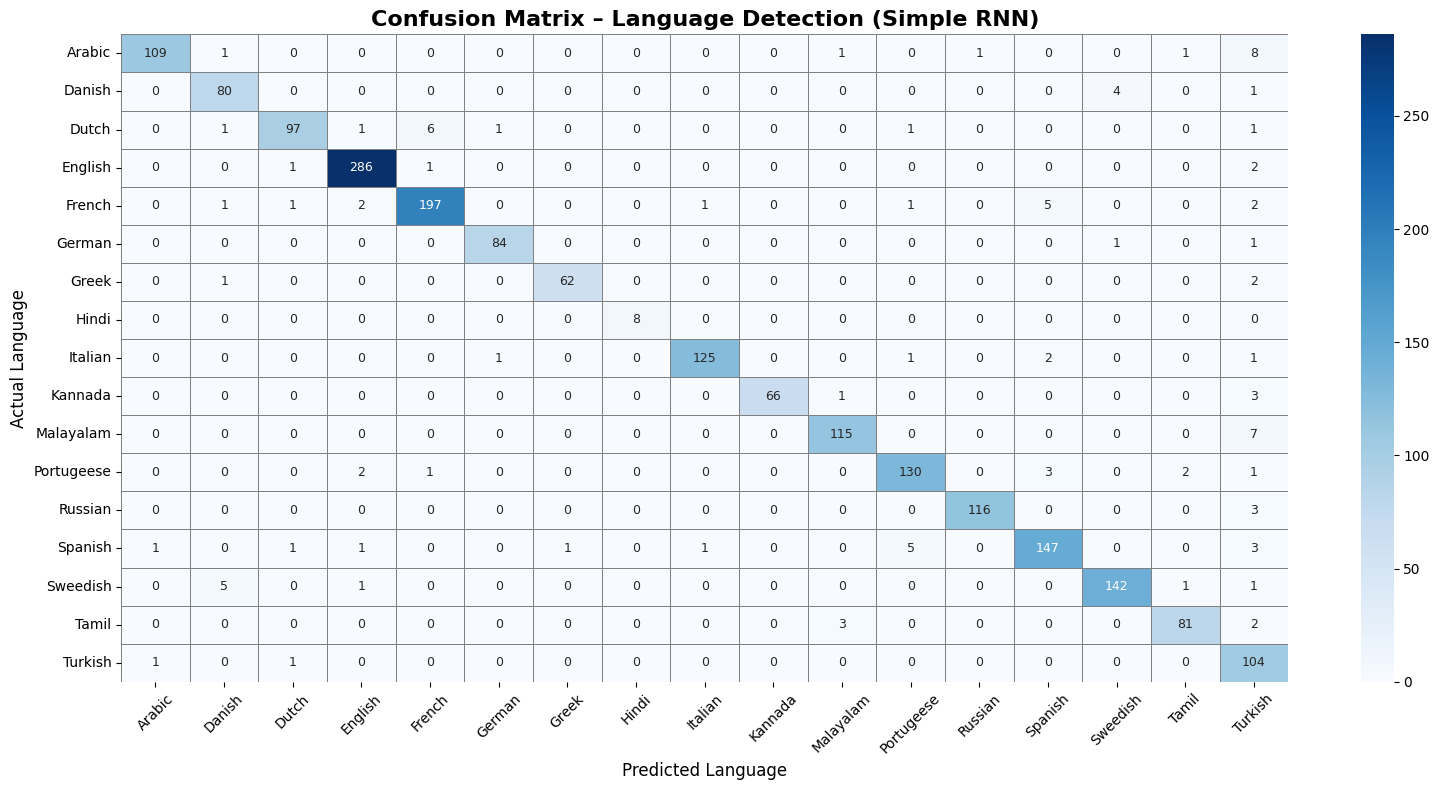

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="grey",
    xticklabels=classes_,
    yticklabels=classes_,
    annot_kws={"size": 9}
)

plt.title("Confusion Matrix – Language Detection (Simple RNN)", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Language", fontsize=12)
plt.ylabel("Actual Language", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()